# Example of Creating Aligned Hierarchies for a Mazurka Score

In this example, we will walk through the elements of the `repytah` package that pertain to the creation of aligned hierarchies for a music-based data stream (eg. a song).

Beginning with features (such as MFCCs and chroma features) for each timestep in your music based data stream, there are several steps to this process:

0. Create the self-dissimilarity matrix (SDM).
1. Highlight pairs of timesteps that are close enough to be considered as repetitions of each other. (In other words, threshold the SDM)
2. Find pairs of structure repetitions (represented as diagonals within the thresholded SDM).
3. Find any pairs of structure repetitions not found in step 2, and group the structure repetitions.
4. Remove any repeated structures that have overlapped instances.
5. Distill the collection of repeated structures into the _essential structure components_ , i.e. the smallest meaningful repetitions on which all larger repeats are constructed. Each timestep will be contained in no more than one essential structure component

_Note_: The walk-through of this example is very similar to code in `example.py` found in this package. 

We begin by importing the necessary packages: 

In [1]:
# NumPy and SciPy are required for mathematical operations
import scipy.io as sio
import numpy as np

# Pandas is used to import the csv
import pandas as pd

# Import all modules from repytah
from repytah import *

# Matplotlib is used to display outputs
import matplotlib.pyplot as plt

# Make the images clear
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Hide code(optional)
import ipywidgets as widgets
from IPython.display import display, HTML
javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}
def toggle_code(state):
    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)
    display(HTML(output))
def button_action(value):
    state = value.new
    toggle_code(state)
    value.owner.description = button_descriptions[state]
state = True
toggle_code(state)
button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")
display(button)

ToggleButton(value=True, description='Hide code')

## Step 0: Create the SDM 

In this phase, there are a few crucial details, namely importing the data file that we would like to unearth hierarchical structural information for and determining the appropriate dissimilarity measure to use. If you already have (symmetrical) matrix representations for your data stream, then you may find it more appropriate to load your matrix and then skip ahead to Step 1 or Step 2. 

This step assumes that your music-based data stream (ie. a recording or score) has already had your preferred features extracted (like chroma or MFCCs) and is arranged into columns such that each column represents a time step (or beat). We refer to this as a _feature vector matrix_ as each feature vector is laid out as column within one cohesive matrix. 

### Importing data for structure analysis

Note: For this demonstration, we are using the `load_ex_data()` built-in function from the `example` module to load our data. To recreate our example, you could do the same. This is an optional task and the normal method of reading in a data file will work.

In [2]:
# Import csv
file_in = load_ex_data('data/input.csv').to_numpy()

fv_mat = file_in

### Creating the SDM

In just one line, we define the self-dissimilarity matrix. This function `create_sdm`, uses feature vectors to create an audio shingle for each time step and represents these shingles as vectors by stacking the relevant feature vectors on top of each other. Then, the cosine distance is found between these shingles.

self_dissim_mat:
 [[0.         0.22990767 0.60920156 ... 0.36852522 0.49159439 0.68528065]
 [0.22990767 0.         0.38503511 ... 0.38467291 0.62490766 0.75097348]
 [0.60920156 0.38503511 0.         ... 0.68539239 0.28160173 0.48359378]
 ...
 [0.36852522 0.38467291 0.68539239 ... 0.         0.71008919 0.7787258 ]
 [0.49159439 0.62490766 0.28160173 ... 0.71008919 0.         0.37657667]
 [0.68528065 0.75097348 0.48359378 ... 0.7787258  0.37657667 0.        ]]


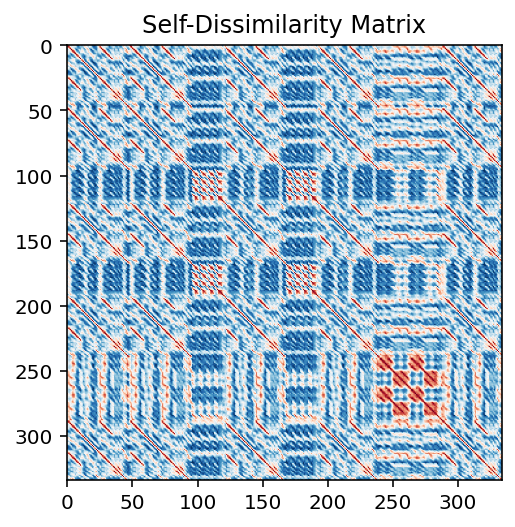

In [3]:
# Number of feature vectors per shingle
num_fv_per_shingle = 3

# Create the self-dissimilarity matrix
self_dissim_mat = create_sdm(fv_mat, num_fv_per_shingle)

print('self_dissim_mat:\n', self_dissim_mat)

# Produce a visualization
SDM = plt.imshow(self_dissim_mat, cmap="RdBu")
plt.title('Self-Dissimilarity Matrix')
plt.show()


## Step 1: Threshold the SDM 

In this step, the self-dissimilarity matrix is thresholded to produce a binary matrix of the same dimensions. This matrix is used to identify repeated structures, which are represented by diagonals of the same length. 

thresh_dist_mat:
 [[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]


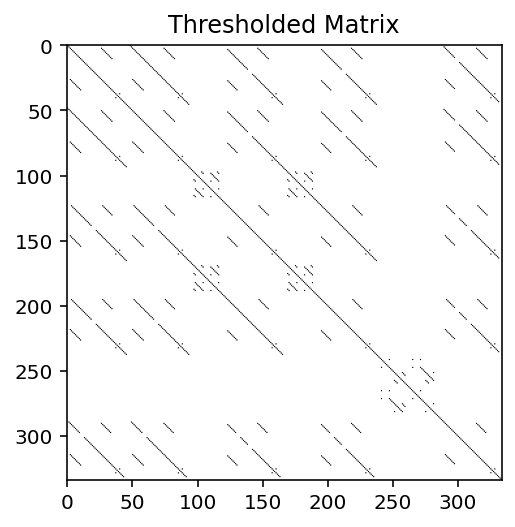

In [4]:
song_length = self_dissim_mat.shape[0]
thresh = 0.01

# Threshold the SDM to produce a binary matrix 
thresh_dist_mat = (self_dissim_mat <= thresh) 

print('thresh_dist_mat:\n', thresh_dist_mat)

# Produce a visualization
SDM = plt.imshow(thresh_dist_mat, cmap="Greys")
plt.title('Thresholded Matrix')
plt.show()

## Step 2: Find the diagonals present and store all pairs of repeats found in a list

The diagonals in the thresholded matrix are found and recorded in an array of repeats. `find_initial_repeats` does this by looking for the largest repeated structures in **thresh_dist_mat**, which are illustrated in the above Thresholded Matrix diagram. Once all repeated structures are found, which are represented as diagonals present in **thresh_dist_mat**, they are stored with their start/end indices and lengths in a list. As each diagonal is found, it is removed to avoid identifying repeated sub-structures.

Below is the listing of the pairs of repeats found by `find_initial_repeats`: 


In [5]:
all_lst = find_initial_repeats(thresh_dist_mat, np.arange(1, song_length + 1), 0)
    
print('all_lst:\n', all_lst)

all_lst:
 [[ 38  38  41  41   1]
 [ 38  38  89  89   1]
 [ 38  38 161 161   1]
 [ 38  38 233 233   1]
 [ 38  38 329 329   1]
 [ 41  41  86  86   1]
 [ 41  41 158 158   1]
 [ 41  41 230 230   1]
 [ 41  41 326 326   1]
 [ 86  86  89  89   1]
 [ 86  86 161 161   1]
 [ 86  86 233 233   1]
 [ 86  86 329 329   1]
 [ 89  89 158 158   1]
 [ 89  89 230 230   1]
 [ 89  89 326 326   1]
 [105 105 111 111   1]
 [105 105 183 183   1]
 [111 111 117 117   1]
 [111 111 177 177   1]
 [111 111 189 189   1]
 [117 117 183 183   1]
 [158 158 161 161   1]
 [158 158 233 233   1]
 [158 158 329 329   1]
 [161 161 230 230   1]
 [161 161 326 326   1]
 [177 177 183 183   1]
 [183 183 189 189   1]
 [230 230 233 233   1]
 [230 230 329 329   1]
 [233 233 326 326   1]
 [242 242 248 248   1]
 [242 242 266 266   1]
 [242 242 272 272   1]
 [248 248 266 266   1]
 [252 252 282 282   1]
 [266 266 272 272   1]
 [276 276 282 282   1]
 [326 326 329 329   1]
 [ 98  99 104 105   2]
 [ 98  99 116 117   2]
 [ 98  99 176 177   2]
 

Let's take moment to examine what we have and time it back to the original thresholded SDM. The first nine pairs listed in **all_lst** are repeats of length 1. We also note that the last "pair" of repeats is the whole score being matched to itself. For now, we set this "repeat" and the ones that are of length 1 aside. 

In the below image, for each pair of repeats, we color one of the two diagonals associated to that pairing. The second one is the matching diagonal when flipped over the main diagonal. The red diagonal represents the pair of repeats that start at beat 4 and 52 and is 11 beats long. Similarly, the blue diagonal represents the pair of repeats that start at beat 4 and 100 and is 11 beats long. Lastly the yellow diagonal represents the pair of repeats that start at beat 26 and 74 and is 46 beats long.

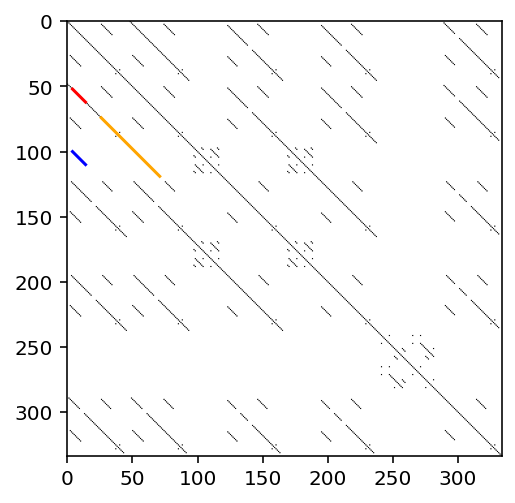

In [6]:
# Produce a visualization
SDM = plt.imshow(thresh_dist_mat, cmap="Greys")

# for [4, 14, 52, 62, 11] in all_lst
x = [4, 14]
y = [52, 62]
plt.plot(x, y, color = "red")

# for [4, 14, 100, 110, 11] in all_lst
x1 = [4, 14]
y1 = [100, 110]
plt.plot(x1, y1, color = "blue")

# for [26, 71, 74, 119, 46] in all_lst
x2 = [26, 71]
y2 = [74, 119]
plt.plot(x2, y2, color = "orange")

plt.show()

## Step 3: Find any diagonals in the thresholded matrix T that are contained in larger diagonals in T but not found in step 2, then group pairs of repeats

Any diagonals that are contained in larger diagonals are found and added to the array of repeats. All possible repeat lengths are looped over in **all_lst**, and larger repeats containing smaller repeats are broken up into up to 3 sections each, the part before the overlap, the overlap, and the part after the overlap. With this, a more complete list of repeated structures is created. 



In [7]:
complete_lst = find_complete_list(all_lst, song_length)
    
print('complete_lst:\n', complete_lst)

complete_lst:
 [[  1   1  49  49   1   1]
 [  2   2 290 290   1   2]
 [ 50  50 290 290   1   2]
 ...
 [100 166 172 238  67   1]
 [ 71 142 143 214  72   1]
 [ 95 166 167 238  72   2]]


It is clear that **complete_list** is much longer that **all_lst**, which makes sense because we are adding smaller pieces of the larger repeats, when an overlap in time has occured between a smaller repeat and a larger one. For example the repeat of length 46 starting at beats 26 and 74 overlaped with the smaller repeat (of length 11) starting at 52. 

The visualization below shows some of the smaller repetitions found within the larger repeats. This image shows the idea of distilling smaller parts from larger repeats in step 2. 

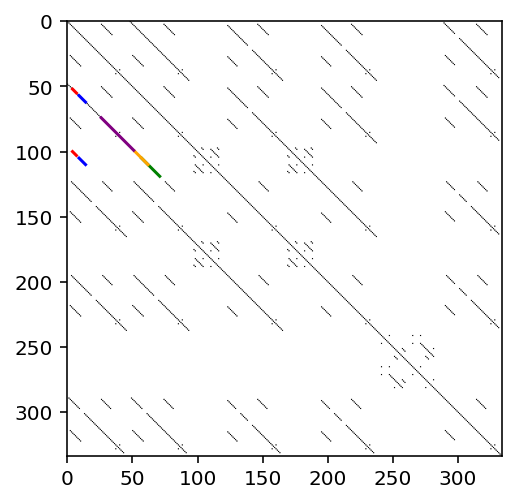

In [8]:
# Produce a visualization
SDM = plt.imshow(thresh_dist_mat, cmap="Greys")

# for [4, 7, 52, 55, 4] in complete_lst
x = [4, 7]
y = [52, 55]
plt.plot(x, y, color = "red")

# for [4, 7, 100, 103, 4] in complete_lst
x = [4, 7]
y = [100, 103]
plt.plot(x, y, color = "red")

# for [9, 14, 57, 62, 6] in complete_lst
x = [9, 14]
y = [57, 62]
plt.plot(x, y, color = "blue")

# for [9, 14, 105, 110, 6] in complete_lst
x = [9, 14]
y = [105, 110]
plt.plot(x, y, color = "blue")

# for [57, 71, 105, 119, 15] in complete_lst
x = [57, 71]
y = [105, 119]
plt.plot(x, y, color = "green")

# for [52, 62, 100, 110, 11] in complete_lst
x = [52, 62]
y = [100, 110]
plt.plot(x, y, color = "orange")

# for [26, 51, 74, 99, 26] in complete_lst
x = [26, 51]
y = [74, 99]
plt.plot(x, y, color = "purple")

plt.show()

## Step 4: Remove any repeated structure that has at least two repeats that overlap in time

In this step, repeated structures with the same annotation and length are removed if they are overlapping.

This is done by looping over all possible repeat lengths, finding all the groups of repeats of the same length. For each of those groups, `remove_overlaps` determines whether there exists any pair of repeats that overlaps in time. If a pair like that exists, all the overlapping repeats are removed. 

Along with a list of all the repeats with no overlaps, this step also forms a matrix, a list of the associated lengths of the repeats in the matrix, the annotations of the repeats in the matrix, and a list of the overlaps. The matrix is a binary matrix that visualizes the repeats, representing the start of a repeat with a 1. This matrix, in combination with the list of the lengths of the repeats, can be used to visualize the repeats. 


In [9]:
output_tuple = remove_overlaps(complete_lst, song_length)

print('List with no overlaps:\n', output_tuple[0])
print('Matrix with no overlaps:\n', output_tuple[1])
print('Lengths of the repeats in the matrix:', output_tuple[2])
print('Annotations of the repeats in the matrix:', output_tuple[3])
print('List of overlaps:\n', output_tuple[4])

List with no overlaps:
 [[  1   1  49  49   1   1]
 [  2   2 290 290   1   2]
 [  3   3  27  27   1   3]
 ...
 [100 166 172 238  67   1]
 [ 71 142 143 214  72   1]
 [ 95 166 167 238  72   2]]
Matrix with no overlaps:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Lengths of the repeats in the matrix: [ 1  1  1  1  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  5
  5  5  6  6  6  6  6  7  7  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10
 11 11 11 12 12 13 13 14 15 16 16 18 21 22 22 22 24 24 25 25 26 27 27 27
 27 27 28 29 31 31 33 34 35 35 36 36 37 37 39 40 40 43 45 46 46 48 49 50
 52 53 53 53 55 56 59 60 61 63 63 66 67 72 72]
Annotations of the repeats in the matrix: [1 2 3 4 5 6 7 8 9 1 2 3 4 5 1 2 3 4 5 1 2 3 4 1 2 3 1 2 3 4 5 1 2 1 2 3 4
 1 2 3 4 5 6 1 2 3 4 5 1 2 3 1 2 1 2 1 1 1 2 1 1 1 2 3 1 2 1 2 1 1 2 3 4 5
 1 1 1 2 1 1 1 2 1 2 1 2 1 1 2 1 1 1 2 1 1 1 1 1 2 3 1 1 1 1 1 1 2 1 1 1 2]
List of overlaps:

## Step 5: Find the essential structure components of the song and build the aligned hierarchies

Building the aligned hierarchies takes two final steps: finding the essential structure components and using them to create the full aligned hierarchies. `hierarchical_structure` first finds the essential structure components with `breakup_overlaps_by_intersect`. After this, modified versions of steps 2-4 take place to create the full hierarchical structure. 

### Essential Structure Components

The essential structure components are the structure building blocks; that is they are the smallest meaningful repeated structures. All repeated structures within a pieces are constructed with right and left unions of the essential structure components. Each timestep can be in at most **one** essential structure component. The first panel in the below image shows the essential structure components for our example piece. The visualization is organized such that there is one row per type of repeat. Notice that we have five types of repeats in the below example. 

### Creating the aligned hierarchies

After finding the essential structure components for a song, we build the aligned hierarchies using a process whose result is akin to taking right and left unions of the essential structure components. The process begins by creating a list of the essential structure components in the order they appear. We assign each essential structure component the number of the row that it sits in. For consectutive timesteps where there is not essential structure component, we use 0 for that block. In the below example, this list would be: 0,2,1,3,1,0,5,2,1,3,1,4,0,5,2,1,3,1,4. 

Using this list, a thresholded dissimilarity matrix is created. Using steps similar to steps two through four above, we can extract information about the combinations of essential structures. From the thresholded dissimilarity matrix, all diagonals are extracted, starting with the longest one, but are not removed. This way, all possible combinations of essential structure components are found. Then, all these combinations are grouped and checked for overlapping repeated combinations. The final product is then restructured to show the widths and annotations for each type of repeated structure (represented by each row).

The figures below represents the final result we get, including two of the most important images: the essential structure components (top most panel) and the complete hierarchical structure (bottom panel).

The figure below with the name _Threshold Self-dissimilarity matrix of the ordering Essential Structure Components_ shows the square thresholded self-dissimilarity matrix such that the (i,j) entry is 1 if the following three conditions are true:

* A repeat of an essential structure component is the i-th item in the ordering.
* A repeat of an essential structure component is the j-th item in the ordering.
* The repeat occurring in the i-th place of the ordering and the one occurring in the j-th place of the ordering are repeats of the same essential structure component.

The figure below with the name _Repeated ordered sublists of the Essential Structure Components_ is the result of extracting all the diagonals and getting pairs of repeated ordered sublists of the essential structure components. The repetitive copies of the same repeat and overlaps are also removed. 

The second to last figure labeled _Repeated ordered sublists of the Essential Structure Components with leading index highlighted_ contains the same repeats as _Repeated ordered sublists of the Essential Structure Components_ but only notes the starting item in black and shows the rest of the repeat in gray. 

The aligned hierarchies are shown in the last image. This is the result of stretching each essential structure component to its correct length (ie. the one noted in the first image below). This transformation results in a visualization that is the width of the original song. 

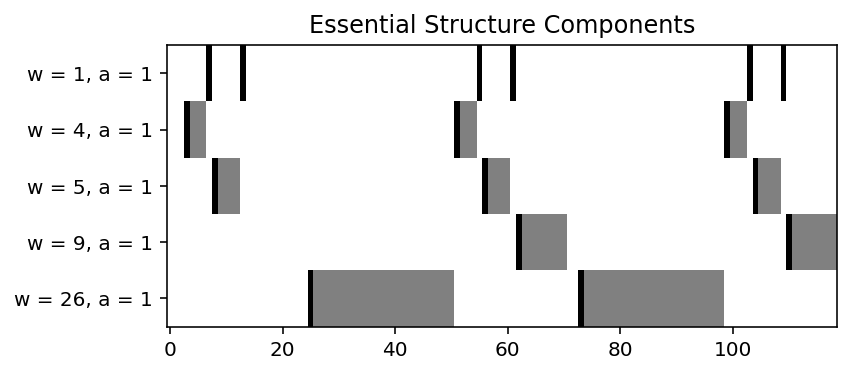

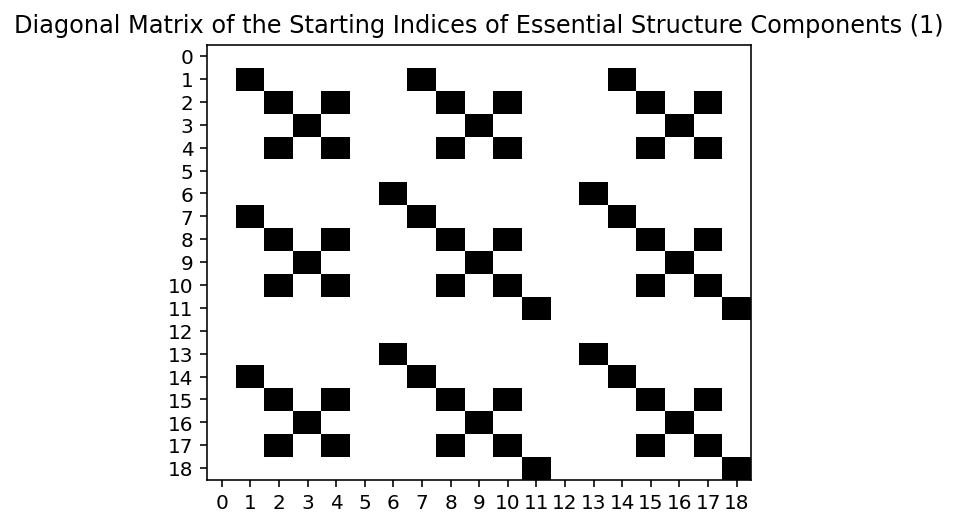

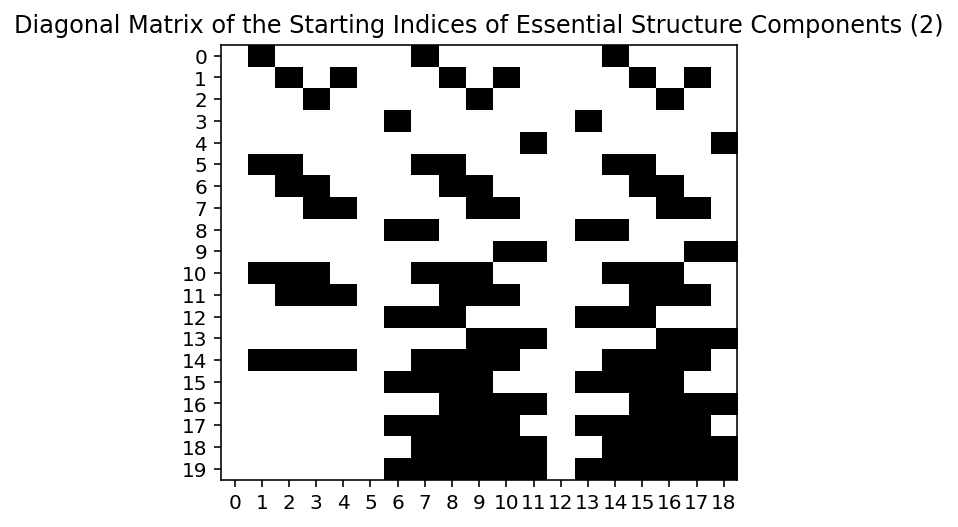

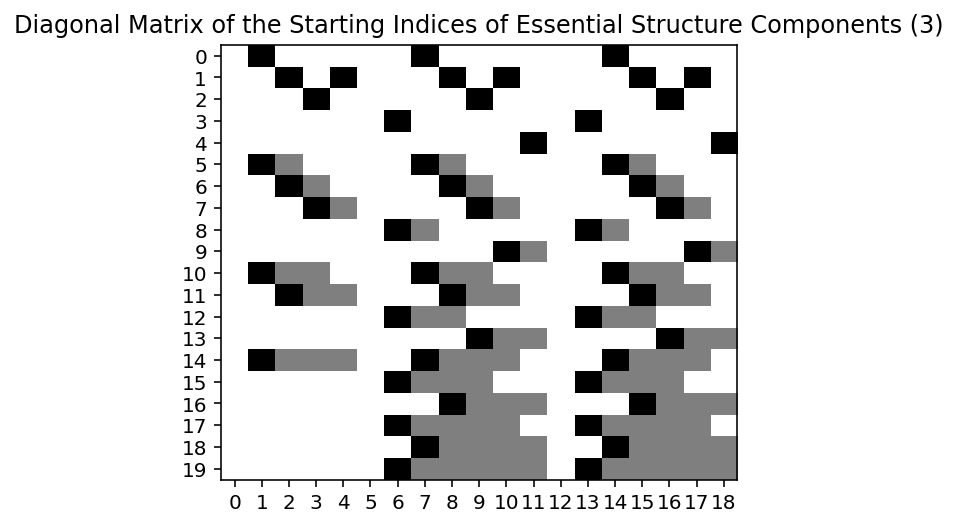

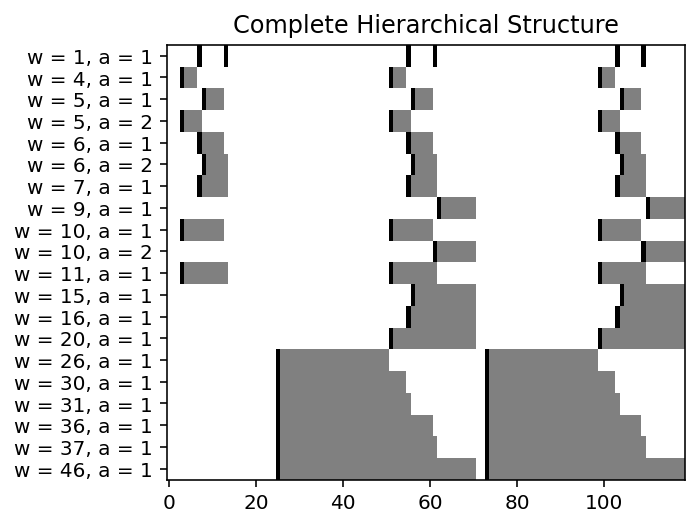

In [10]:
(mat_no_overlaps, key_no_overlaps) = output_tuple[1:3]

# Distill non-overlapping repeats into essential structure components and
# use them to build the hierarchical representation
output_tuple = hierarchical_structure(mat_no_overlaps, key_no_overlaps, song_length, vis=True)
